### Portfolio Management Recommender Tool
#### Author: Naren Mohan, Sai Rahul Valladi, Venkateshwaran Sundar
Intended to analyze the inter market trends and forecast the prices of various assets such as equities, commodities, bonds etc. 

#### Nov 25th Plan - 

- Get data: Time period: 2000 - 2020 
- Get equity data
- Get indices data
- Get bonds data
- Get commodities data

- Merge all the data 
- Split train, test and validation data set
- Create feature set
- Time series forecasting pipeline for all the assets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dropout, Dense
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, pacf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [45]:
start = "1997-01-01"
end = "2021-01-01"
stock_symbols = ["MSFT", "AMD", "AMZN", "GE", "AAPL", "PFE", "KO", "WMT", "COST", "T", "CMCSA", "PEP",
                 "KO", "UL", "BAC", "JPM", "GS", "MS", "NOC", "LMT", "BA", "F", "LUV", "SLB", "NEE", "MCD",
                 "SBAC", "AMT", "JNJ"] + ["^GSPC", "^DJI", "^IXIC", "^NYA", "^RUT", "^N100"] + ["JPY=X"]

commodity_symbols = ["^IRX", "^FVX", "^TNX"] + ["FDCAX", "GMCFX", "FRESX", "FRRSX", "FSLBX", "VDIGX", "SGGDX", "OPGSX"] \
                    + ["CL", "HE", "B", "NBP", "GL"]
# ["GC=F", "SI=F", "HG=F", "CL=F", "NG=F"]
interval = 'd'
n_periods = 176  # 176 days prediction into future
n_future = 1  # number of future stock prices to predict while training
n_lags = 14  # number of past stock price to consider while training
forecasted = []
# causality_data = []

master_data = pdr.get_data_yahoo(stock_symbols + commodity_symbols, start, end, interval=interval)['Adj Close']
master_data.dropna(inplace=True)

In [46]:
for i in range(len(stock_symbols)):
    data = master_data.loc[:, [stock_symbols[i]] + commodity_symbols]
    print(data.shape)
    # symbols = [stock_symbol] + commodity_symbols

    # Getting the data
    # data = pdr.get_data_yahoo(symbols, start, end, interval=interval)['Adj Close']
    # print(data.shape)

    # fill NaN values with back fill
    # data.fillna(method='bfill', inplace=True)
    # data.dropna(inplace=True)

    # normalizing the data
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    data_scaled = scaler.transform(data)

    trainX = []
    trainY = []

    for index in range(n_lags, len(data_scaled) - n_future + 1):
        trainX.append(data_scaled[index - n_lags: index, :data_scaled.shape[1]])
        trainY.append(data_scaled[index + n_future - 1: index + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)
    # print(trainX.shape, trainY.shape)

    # model = Sequential()
    # model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    # model.add(LSTM(32, activation='relu', return_sequences=False))
    # model.add(Dropout(0.2))
    # model.add(Dense(trainY.shape[1]))
    # model.compile(optimizer='adam', loss='mse')
    # # model.summary()
    #
    # checkpoint = ModelCheckpoint(filepath='model_{0}'.format(stock_symbol), monitor='val_loss',
    #                              verbose = 2, save_best_only = True, mode ='min')
    #
    # history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=2,
    #                     callbacks=[checkpoint])
    #
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.show()

    best_model = tf.keras.models.load_model('model_{0}'.format(stock_symbols[i]))
    forecasted_prices_scaled = best_model.predict(trainX[-n_periods:])

    forecast_copies = np.repeat(forecasted_prices_scaled, data_scaled.shape[1], axis=-1)
    forecasted_prices = scaler.inverse_transform(forecast_copies)[:, 0]
    # print(forecasted_prices.shape)

    forecasted.append(list(forecasted_prices))
    # print(data[-n_periods:].index)
    # print(forecasted_prices.shape, data.iloc[-n_periods:, 0].shape)

    # print("MSE for {0}: ".format(stock_symbol), mean_squared_error(data.iloc[-n_periods:, 0], forecasted_prices))

    # plt.title(stock_symbol)
    # plt.xlabel('Datetime')
    # plt.ylabel('Adjusted Closing Prices')
    # plt.plot(data[-n_periods:].index, data.iloc[-n_periods:, 0])
    # plt.plot(data[-n_periods:].index, forecasted_prices)
    # plt.legend(['Actual', 'Forecasted'])
    # plt.show()

    # # Display
    # plt.figure(figsize=(20, 10))
    # plt.xlabel('Datetime')
    # plt.ylabel('Daily Prices ($)')
    # plt.title('Closing Prices from {} to {}'.format(start, end))
    # plt.plot(data)
    # plt.legend([stock_symbol] + commodity_symbols)
    # plt.show()

    # print(data.isnull().sum())

    # print(data.corr())

    # # if p-value of this test is >0.05 then data is non-stationary which has to be made stationary for ARIMA to work
    # opt_diff = float('-inf')
    # for symbol in symbols:
    #     diff = 0
    #     while True:
    #         if diff == 0:
    #             adfuller_result = adfuller(data[symbol])
    #         else:
    #             adfuller_result = adfuller(data[symbol].diff(periods=diff)[diff:])
    #
    #         pvalue = adfuller_result[1]
    #         if pvalue < .05:
    #             break
    #         else:
    #             diff += 1
    #     opt_diff = max(diff, opt_diff)
    #
    # causality test
    # causality_data.append([])
    # for index in range(len(symbols) - 1):
    #     # print("Causality for {0} and {1}".format(stock_symbol, symbols[index + 1]))
    #     try:
    #         causality = grangercausalitytests(data.iloc[:, [0, index + 1]], maxlag=15, verbose=False)
    #         ssr_ftest_pvalue = causality[n_lags][0]['ssr_ftest'][1]
    #         causality_data[i].append(ssr_ftest_pvalue)
    #     except ValueError:
    #         causality_data[i].append('NaN')
    #         continue

    #
    # # split into train and test
    # train_data = data.iloc[:-30, :]
    # test_data = data.iloc[-30:]
    #
    # # finding optimal lags
    # model = VAR(train_data.diff(periods=opt_diff)[opt_diff:])
    # sorted_model = model.select_order(maxlags=10)
    # p = np.argmin(sorted_model)
    #
    # # train the model
    # var_model = VARMAX(train_data, order=(1, 0), enforce_stationarity=True)
    # fitted_model = var_model.fit(disp=False)
    #
    # predict = fitted_model.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    # predictions = predict.predicted_mean
    #
    # plt.plot(test_data.index, test_data[stock_symbol])
    # plt.plot(test_data.index, predictions[stock_symbol])
    # plt.show()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400,0,0
2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700,0,0
2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600,0,0
2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000,0,0
2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200,0,0
...,...,...,...,...,...,...,...
2022-12-05,121.750000,124.669998,121.349998,122.430000,35474900,0,0
2022-12-06,119.910004,120.550003,113.739998,114.120003,43689200,0,0
2022-12-07,113.760002,115.879997,112.879997,113.930000,29461100,0,0


In [ ]:
forecasted = np.array(forecasted).T
df_fcst = pd.DataFrame(forecasted, index=master_data[-n_periods:].index, columns=stock_symbols)

In [ ]:
def alphaCalculator(df_fcst):
    start_price = df_fcst.iloc[0]
    df_fcst = df_fcst.ffill()
    df_fcst_SMA = df_fcst.rolling(7).mean()
    max_fcst = df_fcst_SMA.max()
    max_fcst_date = df_fcst_SMA.idxmax()

    vals = df_fcst_SMA.dropna().values
    ind = list(range(len(vals)))
    ind = np.array(ind).reshape((-1, 1))

    try:
        model = LinearRegression()
        model.fit(ind, vals)
    except ValueError:
        print(df_fcst.name)
        
    r_sq = model.score(ind, vals)
    # print(df_fcst.name, r_sq)

    returns = (max_fcst / start_price) - 1
    alpha = returns * r_sq

    return alpha


def recommender(df, threshold):
    instruments = df.columns
    recommendations = dict()
    alpha_dict = dict()

    for inst in instruments:
        alpha = alphaCalculator(df[inst])
        alpha_dict[inst] = alpha
        if alpha > threshold:
            recommendations[inst] = alpha
    
    return recommendations



In [ ]:
df_pred = pd.read_csv("predictions.csv")
df_pred.set_index("Date", inplace=True)
df_pred.head()

In [47]:
stocks_tickers = ["MSFT", "AMD", "AMZN", "GE", "AAPL", "PFE", "KO", "WMT", "COST", "T", "CMCSA", "PEP", \
    "KO", "UL", "BAC", "JPM", "GS", "MS", "NOC", "LMT", "BA", "F", "LUV", "SLB", "NEE", "MCD",
        "SBAC", "AMT", "JNJ"]
index_tickers = ["^GSPC", "^DJI", "^IXIC", "^NYA", "^RUT", "^N100"]
currency_tickers = ["JPY=X"]
# crypto_tickers = ["BTC-USD", "ETH-USD"]
bonds_tickers = ["^IRX", "^FVX", "^TNX"]
mf_tickers = ["FDCAX", "GMCFX", "FRESX", "FRRSX", "FSLBX", "VDIGX", "SGGDX", "OPGSX"]
comm_tickers = ["CL", "HE", "B", "NBP", "GL"]

tickers = stocks_tickers + index_tickers + currency_tickers  + bonds_tickers + mf_tickers + comm_tickers

In [48]:
period = "2000-01-01"

df = yf.download(tickers, start="2000-01-01")
df["Adj Close"]

[*********************100%***********************]  51 of 51 completed


,AAPL,AMD,AMT,AMZN,B,BA,BAC,CL,CMCSA,COST,...,WMT,^DJI,^FVX,^GSPC,^IRX,^IXIC,^N100,^NYA,^RUT,^TNX
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.851942,15.500000,23.893415,4.468750,4.890864,25.940287,13.443512,19.092178,11.772093,30.975517,...,44.220284,11357.509766,6.457,1455.219971,5.270,4131.149902,996.770020,6762.109863,496.420013,6.548
2000-01-04,0.780115,14.625000,23.638689,4.096875,4.777997,25.899944,12.645564,18.593784,10.890763,29.278826,...,42.565651,10997.929688,6.396,1399.420044,5.270,3901.689941,955.969971,6543.759766,478.380005,6.485
2000-01-05,0.791530,15.000000,24.351921,3.487500,4.740375,27.513651,12.784348,17.961216,10.607474,29.779140,...,41.696949,11122.650391,6.489,1402.109985,5.270,3877.540039,930.260010,6567.029785,478.829987,6.599
2000-01-06,0.723033,16.000000,24.097202,3.278125,4.702755,27.796038,13.877164,17.922871,11.016670,30.377329,...,42.151978,11253.259766,6.450,1403.449951,5.240,3727.129883,922.460022,6635.439941,475.339996,6.549
2000-01-07,0.757282,16.250000,25.421782,3.478125,4.665131,28.602905,13.512892,18.996332,10.670430,32.389435,...,45.337166,11522.559570,6.397,1441.469971,5.220,3882.620117,943.880005,6792.669922,488.309998,6.504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05,146.630005,73.620003,215.610001,91.010002,41.439999,185.100006,34.470001,77.120003,35.150002,488.660004,...,151.080460,33947.101562,3.793,3998.840088,4.158,11239.940430,1281.959961,15474.790039,1840.219971,3.599
2022-12-06,142.910004,70.269997,212.520004,88.250000,40.139999,178.429993,33.000000,77.209999,34.770000,481.160004,...,149.327072,33596.339844,3.733,3941.260010,4.220,11014.889648,1277.209961,15328.459961,1812.579956,3.513
2022-12-07,140.940002,70.139999,211.110001,88.459999,40.520000,176.500000,32.740002,77.550003,34.619999,481.970001,...,148.550003,33597.921875,3.614,3933.919922,4.183,10958.549805,1268.599976,15311.790039,1806.900024,3.408


In [49]:
sum(df.loc[:, "Adj Close"].iloc[0,:].isna())

0

In [50]:
df = df["Adj Close"].reset_index()
df

,Date,AAPL,AMD,AMT,AMZN,B,BA,BAC,CL,CMCSA,...,WMT,^DJI,^FVX,^GSPC,^IRX,^IXIC,^N100,^NYA,^RUT,^TNX
0,2000-01-03,0.851942,15.500000,23.893415,4.468750,4.890864,25.940287,13.443512,19.092178,11.772093,...,44.220284,11357.509766,6.457,1455.219971,5.270,4131.149902,996.770020,6762.109863,496.420013,6.548
1,2000-01-04,0.780115,14.625000,23.638689,4.096875,4.777997,25.899944,12.645564,18.593784,10.890763,...,42.565651,10997.929688,6.396,1399.420044,5.270,3901.689941,955.969971,6543.759766,478.380005,6.485
2,2000-01-05,0.791530,15.000000,24.351921,3.487500,4.740375,27.513651,12.784348,17.961216,10.607474,...,41.696949,11122.650391,6.489,1402.109985,5.270,3877.540039,930.260010,6567.029785,478.829987,6.599
3,2000-01-06,0.723033,16.000000,24.097202,3.278125,4.702755,27.796038,13.877164,17.922871,11.016670,...,42.151978,11253.259766,6.450,1403.449951,5.240,3727.129883,922.460022,6635.439941,475.339996,6.549
4,2000-01-07,0.757282,16.250000,25.421782,3.478125,4.665131,28.602905,13.512892,18.996332,10.670430,...,45.337166,11522.559570,6.397,1441.469971,5.220,3882.620117,943.880005,6792.669922,488.309998,6.504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,2022-12-05,146.630005,73.620003,215.610001,91.010002,41.439999,185.100006,34.470001,77.120003,35.150002,...,151.080460,33947.101562,3.793,3998.840088,4.158,11239.940430,1281.959961,15474.790039,1840.219971,3.599
5981,2022-12-06,142.910004,70.269997,212.520004,88.250000,40.139999,178.429993,33.000000,77.209999,34.770000,...,149.327072,33596.339844,3.733,3941.260010,4.220,11014.889648,1277.209961,15328.459961,1812.579956,3.513
5982,2022-12-07,140.940002,70.139999,211.110001,88.459999,40.520000,176.500000,32.740002,77.550003,34.619999,...,148.550003,33597.921875,3.614,3933.919922,4.183,10958.549805,1268.599976,15311.790039,1806.900024,3.408
5983,2022-12-08,142.649994,70.470001,212.250000,90.349998,40.360001,179.080002,32.439999,78.139999,34.970001,...,148.779999,33781.480469,3.710,3963.510010,4.150,11082.000000,1269.510010,15399.940430,1818.290039,3.491


In [135]:
df_fcst = df[-200:].copy()
df_fcst.set_index("Date", inplace=True)
df_fcst.drop("NBP", axis=1, inplace=True)
df_fcst

,AAPL,AMD,AMT,AMZN,B,BA,BAC,CL,CMCSA,COST,...,WMT,^DJI,^FVX,^GSPC,^IRX,^IXIC,^N100,^NYA,^RUT,^TNX
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-07,158.582581,102.949997,227.758514,137.453003,41.659332,169.169998,37.650791,75.274437,45.328506,525.803101,...,139.477509,32817.378906,1.691,4201.089844,0.305,12830.959961,1150.430054,15708.230469,1951.329956,1.751
2022-03-08,156.730957,105.529999,223.782913,136.014496,41.738255,173.800003,37.896297,73.497620,45.162075,520.669617,...,136.592865,32632.640625,1.806,4170.700195,0.360,12795.549805,1144.439941,15625.929688,1963.010010,1.872
2022-03-09,162.216141,111.050003,228.828491,139.279007,42.537304,178.559998,40.302254,74.155342,45.152283,524.937622,...,137.301727,33286.250000,1.880,4277.879883,0.370,13255.549805,1210.280029,15977.540039,2016.290039,1.948
2022-03-10,157.806107,106.459999,228.524200,146.817505,41.580418,178.389999,39.938908,72.486496,44.437599,529.981506,...,140.422653,33174.070312,1.941,4259.520020,0.360,13129.959961,1182.489990,15929.559570,2011.670044,2.011
2022-03-11,154.033157,104.290001,230.526718,145.524506,40.820816,176.229996,39.605022,72.417778,44.075363,524.708740,...,139.871338,32944.191406,1.960,4204.310059,0.365,12843.809570,1192.109985,15753.700195,1979.670044,2.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05,146.630005,73.620003,215.610001,91.010002,41.439999,185.100006,34.470001,77.120003,35.150002,488.660004,...,151.080460,33947.101562,3.793,3998.840088,4.158,11239.940430,1281.959961,15474.790039,1840.219971,3.599
2022-12-06,142.910004,70.269997,212.520004,88.250000,40.139999,178.429993,33.000000,77.209999,34.770000,481.160004,...,149.327072,33596.339844,3.733,3941.260010,4.220,11014.889648,1277.209961,15328.459961,1812.579956,3.513
2022-12-07,140.940002,70.139999,211.110001,88.459999,40.520000,176.500000,32.740002,77.550003,34.619999,481.970001,...,148.550003,33597.921875,3.614,3933.919922,4.183,10958.549805,1268.599976,15311.790039,1806.900024,3.408


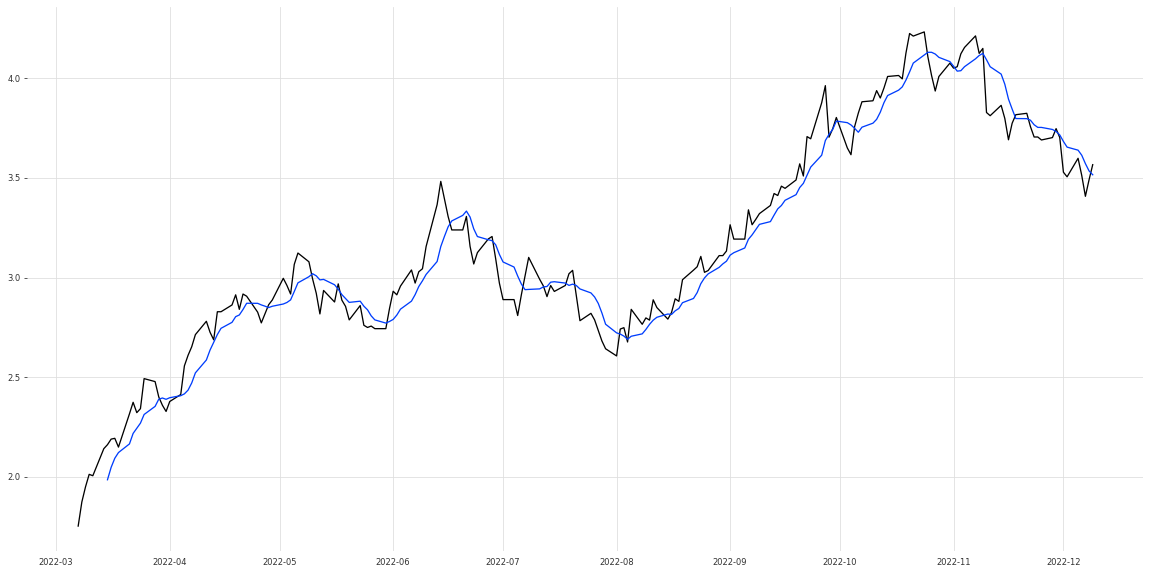

In [141]:
df_fcst["^TNX"] = df_fcst["^TNX"].ffill()
plt.figure(figsize=(20, 10))
plt.plot(df_fcst.index, df_fcst["^TNX"])
plt.plot(df_fcst.index, df_fcst["^TNX"].rolling(7).mean())



In [91]:
df_fcst_AAPL_SMA = df_fcst.AAPL.rolling(7).mean()
df_fcst_AAPL_SMA.idxmax()


5806

In [162]:
df_fcst_AAPL_SMA = df_fcst.T.rolling(7).mean()
df_fcst_AAPL_SMA.idxmax()
vals = df_fcst_AAPL_SMA.dropna().values
ind = list(range(len(vals)))
ind = np.array(ind).reshape((-1, 1))

model = LinearRegression().fit(ind, vals)
model.score(ind, vals)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [147]:
import statsmodels.api as sm
mod = sm.OLS(vals, ind)
fii = mod.fit()
p_val = fii.summary2().tables[1]['P>|t|']

p_val

x1    1.962796e-55
Name: P>|t|, dtype: float64

In [148]:
fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.720    
Dependent Variable:     y                AIC:                         2256.5575
Date:                   2022-12-12 14:21 BIC:                         2259.8253
No. Observations:       194              Log-Likelihood:              -1127.3  
Df Model:               1                F-statistic:                 499.4    
Df Residuals:           193              Prob (F-statistic):          1.96e-55 
R-squared (uncentered): 0.721            Scale:                       6559.8   
-------------------------------------------------------------------------------------
           Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1         1.1646         0.0521       22.3464       0.0000       1.0619       1.2674
-------------------------------------------------------------------------------
Omnibus:                   34.758            Durbin-Watson:               0.000
Prob(Omnibus):             0.000             Jarque-Bera (JB):            8.534
Skew:                      0.091             Prob(JB):                    0.014
Kurtosis:                  1.989             Condition No.:               1    
===============================================================================

"""

In [160]:
def alphaCalculator(df_fcst):
    start_price = df_fcst.iloc[0]
    df_fcst = df_fcst.ffill()
    df_fcst_SMA = df_fcst.rolling(7).mean()
    max_fcst = df_fcst_SMA.max()
    max_fcst_date = df_fcst_SMA.idxmax()

    vals = df_fcst_SMA.dropna().values
    ind = list(range(len(vals)))
    ind = np.array(ind).reshape((-1, 1))

    try:
        model = LinearRegression()
        model.fit(ind, vals)
    except ValueError:
        print(df_fcst.name)
        
    r_sq = model.score(ind, vals)
    # print(df_fcst.name, r_sq)

    returns = (max_fcst / start_price) - 1
    alpha = returns * r_sq

    return alpha


def recommender(df, threshold):
    instruments = df.columns
    recommendations = dict()
    alpha_dict = dict()

    for inst in instruments:
        alpha = alphaCalculator(df[inst])
        alpha_dict[inst] = alpha
        if alpha > threshold:
            recommendations[inst] = alpha
    
    return recommendations



In [156]:
df_pred = pd.read_csv("predictions.csv")
df_pred.set_index("Date", inplace=True)
df_pred.head()

,MSFT,AMD,AMZN,GE,AAPL,PFE,KO,WMT,COST,T,...,SBAC,AMT,JNJ,^GSPC,^DJI,^IXIC,^NYA,^RUT,^N100,JPY=X
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-03,62.161873,5.826747,42.668060,201.46925,31.137165,26.225847,35.710125,63.367040,149.23410,17.272406,...,118.79495,104.611560,98.995155,2318.4226,20186.156,5505.9330,11406.738,1313.3057,960.62300,113.85970
2017-04-04,62.315228,5.873826,43.112328,201.99911,31.320103,26.314363,35.801662,63.433292,149.40198,17.287730,...,118.94718,104.857530,99.195220,2318.2705,20190.400,5508.5580,11402.216,1313.0992,961.98206,113.72131
2017-04-05,62.634895,5.856221,43.665512,202.72700,31.094152,26.423270,35.932480,63.653824,149.76033,17.285618,...,119.39425,105.463974,99.409360,2318.3670,20171.695,5508.9194,11409.802,1312.7424,961.09814,113.43296
2017-04-06,62.675083,5.839309,44.181915,203.14117,31.165867,26.461998,35.983760,63.701218,149.77583,17.281640,...,119.58419,105.610860,99.553440,2315.6558,20170.574,5506.4536,11392.634,1311.0974,961.89430,113.28560
2017-04-10,62.750668,5.766320,44.592304,203.48450,31.247496,26.487045,36.033855,63.701195,149.93393,17.267166,...,119.83667,105.928710,99.708435,2317.8801,20169.664,5508.4670,11400.877,1309.4690,963.51100,113.28458


In [161]:
recommender(df_pred, 0.5)

{'AMZN': 0.6139771795813136,
 'JPM': 0.5831290700007775,
 'BA': 0.5710359822236253}

In [31]:
aapl_ts = TimeSeries.from_dataframe(df1, "Date", "AAPL")

In [32]:
aapl_ts

<TimeSeries (DataArray) (Date: 5985, component: 1, sample: 1)>
array([[[  0.85194212]],

       [[  0.78011489]],

       [[  0.79153055]],

       ...,

       [[140.94000244]],

       [[142.6499939 ]],

       [[142.16000366]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2000-01-03 2000-01-04 ... 2022-12-09
  * component  (component) object 'AAPL'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
train, test = aapl_ts[:5000], aapl_ts[5000:]

In [39]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(test), num_samples=1000)

OSError: dlopen(/Users/naren/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/naren/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [41]:
df = df["Adj Close"]

In [43]:
df = df1["Date"]

In [ ]:
Source: Yfinance
Period: daily
Price: Close Price

Data Cleaning steps: 
Unify all the instruments' prices into one single dataframe

While building the model, we create lag features - 7, 14 day period, 30 day period

Model: LightGBM

